In [5]:
from local.node import Node
from local.constnode import ConstNode
from local.varnode import VarNode
from local.funcnode import FuncNode
from local.func import *
from local.treeoptimizer import TreeOptimizer
from local.crossover import *
from local.Optimizer import *

import os
import json
import glob
import copy
import random
import pickle
import graphviz
import datetime
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, metrics, optimizers
from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
def create_folder():
    date = datetime.datetime.today()
    folder_path = str(date.year)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)

    folder_path += "/"+str(date.month) +"_"+str(date.day)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)

    folder_path += "/"+str(date.hour)+"_"+str(date.minute)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        
    return folder_path


def Tounament_select(score_list, generation, Selection_size):
    candidate = random.sample(range(len(score_list)), Selection_size)
    candidate_score = [score_list[i] for i in candidate]
    index = candidate_score.index(max(candidate_score))
    return copy.deepcopy(generation[candidate[index]])

In [ ]:
Population = 50
Max_generation = 500

Mutation_rate = 0.2
Crossover_rate = 0.8

Selection_size = 2

BATCH_SIZE = 512
EPOCHS = 10

loss_obj = metrics.Mean()
accuracy_obj = metrics.SparseCategoricalAccuracy()
val_loss_obj = metrics.SparseCategoricalCrossentropy()
val_accuracy_obj = metrics.SparseCategoricalAccuracy()

generation = []
generation += [Momentum(learning_rate=0.01) for _ in range(Population // 2)]
generation += [RMSProp() for _ in range(Population // 2)]

best_optim = SGD()
best_score = 0.0
best_score_list = []
past_progress = 0
folder_path = create_folder()
if not os.path.exists(folder_path+"/best_optim/"):
    os.mkdir(folder_path+"/best_optim/")
score_progress = []

In [ ]:
def load_data():
    (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
    x_train, x_test = x_train[..., tf.newaxis] / 255.0, x_test[..., tf.newaxis] / 255.0

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

    return train_dataset, test_dataset

def build_model():
    input = layers.Input(shape = (32, 32, 3))
    x = layers.Conv2D(32, 3, 2)(input)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units = 128, activation = "relu")(x)
    output = layers.Dense(units = 10, activation = "softmax")(x)

    return models.Model(input, output)

train_dataset, test_dataset = load_data()

model = build_model()
model.compile()
if not os.path.exists("models/"):
    os.mkdir("models/")
if not os.path.exists("models/model_cifar.keras"):
    model.save_weights("models/model_cifar.keras")

In [ ]:
# best_score = 0.6003
# folder_path = '2024/1_2/10_4'
# read_folder_path = folder_path +f"/generation{past_progress}"
# pickle_list = glob.glob(read_folder_path +"/*.pickle")
# generation = []
# for path in pickle_list:
#     pickle_file = open(path, "rb")
#     genetic = pickle.load(pickle_file)
#     generation.append(genetic)

In [ ]:
for progress in range(past_progress, Max_generation):
    fitness_list = []
    save_path = folder_path + f"/generation{progress}/"
    if not os.path.exists(save_path):
        os.mkdir(save_path)

    for index in tqdm(range(len(generation))):

        acc_list = []
        optimizer = generation[index]
        optimizer.model_params = list()
        optimizer.grads_params = list()
        model.load_weights("models/model_cifar.keras")
        penalty = 1e-5 * len(optimizer.make_struct_dict().keys())

        @tf.function
        def train_step(X, Y):
            with tf.GradientTape() as tape:
                pred = model(X)
                loss = losses.SparseCategoricalCrossentropy()(Y, pred)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            loss_obj(loss)
            accuracy_obj(Y, pred)
        
            return gradients
        
        @tf.function
        def test_step(X, Y):
            pred = model(X)
            
            val_loss_obj(Y, pred)
            val_accuracy_obj(Y, pred)

        for i in range(EPOCHS):
            
            loss_obj.reset_state()
            accuracy_obj.reset_state()
            val_loss_obj.reset_state()
            val_accuracy_obj.reset_state()
            gradients = 0
            for X, Y in train_dataset:
                gradients = train_step(X, Y)
            
            optimizer.model_params.append(copy.deepcopy(model.trainable_variables))
            optimizer.grads_params.append(copy.deepcopy(gradients))
            
            for X, Y in test_dataset:
                test_step(X, Y)
        
            acc_list.append(val_accuracy_obj.result().numpy())
        fitness_list.append(max(acc_list))
        # 画像保存に時間がかかったのでコメントアウトしてます
        # optimizer.plot_struct(f"{save_path}/optimizer_{index}_{max(acc_list)}")
        pickle_file = open(f"{save_path}/optimizer_{index}_{max(acc_list)}.pickle", mode= "wb")
        pickle.dump(optimizer, pickle_file)
        pickle_file.close()


    for index in range(len(fitness_list)):
        if fitness_list[index] > best_score:
            best_score = fitness_list[index]
            best_optim = copy.deepcopy(generation[index])

            best_optim.plot_struct(f"{folder_path}/best_optim/generation_{progress}_{index}_{best_score}")
            pickle_file = open(f"{folder_path}/best_optim/generation_{progress}_{index}_{best_score}.pickle", mode= "wb")
            pickle.dump(best_optim, pickle_file)
            pickle_file.close()
    
    best_score_list.append(best_score)
    print(best_score)
    json_file = open(f"{folder_path}/best_optim/score{progress}.json", "w")
    json.dump(str(best_score), json_file)
    json_file.close()

    next_generation = []

    # while len(next_generation) < Population:
    #     parent1 = Tounament_select(fitness_list, generation, Selection_size)
    #     parent2 = Tounament_select(fitness_list, generation, Selection_size)

    #     if random.random() < Crossover_rate:
    #         parent1, parent2 = semantic_crossover(parent1, parent2, progress, Max_generation)
        
    #     next_generation.append(parent1)
    #     next_generation.append(parent2)
    next_generation = copy.deepcopy(generation)
    for index, genetic in enumerate(next_generation):
        if random.random() < Mutation_rate:
            genetic.mutate()

    next_generation.append(copy.deepcopy(best_optim))
    next_generation.append(Momentum())
    next_generation.append(RMSProp())
    
    generation = next_generation[len(next_generation) - Population:]

    # pickleファイルが思ったより容量大きかったので、現世代の評価と進化が終わったら、ひとつ前の世代のpickleファイルを削除
    check_path = folder_path + f"/generation{progress -1}"
    pickle_list = glob.glob(check_path +"/*.pickle")
    for path in pickle_list:
        os.remove(path)

    past_progress = progress

In [6]:
best_optim = pickle.load(open("./2024/1_2/10_4/best_optim/generation_371_47_0.6003000140190125.pickle", "rb"))

BATCH_SIZE = 512
def load_data_cifar10():
    (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
    x_train, x_test = x_train[..., tf.newaxis] / 255.0, x_test[..., tf.newaxis] / 255.0

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

    return train_dataset, test_dataset

def load_data_cifar100():
    (x_train, y_train), (x_test, y_test) = datasets.cifar100.load_data()
    x_train, x_test = x_train[..., tf.newaxis] / 255.0, x_test[..., tf.newaxis] / 255.0

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

    return train_dataset, test_dataset

def load_data_mnist():
    (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
    x_train, x_test = x_train[..., tf.newaxis] / 255.0, x_test[..., tf.newaxis] / 255.0

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

    return train_dataset, test_dataset

def build_model_cifar():
    input = layers.Input(shape = (32, 32, 3))
    x = layers.Conv2D(32, 3, 2)(input)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units = 128, activation = "relu")(x)
    output = layers.Dense(units = 10, activation = "softmax")(x)

    return models.Model(input, output)

def build_model_cifar100():
    input = layers.Input(shape = (32, 32, 3))
    x = layers.Conv2D(32, 3, 2, "same")(input)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(64, 3, 2, "same")(input)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units = 128, activation = "relu")(x)
    x = layers.Dense(units = 256, activation = "relu")(x)
    output = layers.Dense(units = 100, activation = "softmax")(x)

    return models.Model(input, output)
    return model

def build_model_mnist():
    input = layers.Input(shape = (28, 28, 1))
    x = layers.Conv2D(32, 3, 2)(input)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units = 128, activation = "relu")(x)
    output = layers.Dense(units = 10, activation = "softmax")(x)

    return models.Model(input, output)


loss_obj = metrics.Mean()
accuracy_obj = metrics.SparseCategoricalAccuracy()
val_loss_obj = metrics.SparseCategoricalCrossentropy()
val_accuracy_obj = metrics.SparseCategoricalAccuracy()

In [15]:
train_dataset, test_dataset = load_data_cifar100()

# VGG16のモデルと重みをインポート
input_tensor = layers.Input(shape=(32, 32, 3))
vgg16_model = VGG16(
    include_top=False, #全結合層を除外
    weights='imagenet',
    input_tensor=input_tensor
    )

# 重みを固定
for layer in vgg16_model.layers:
  layer.trainable = False
  
@tf.function
def train_step(X, Y):
    with tf.GradientTape() as tape:
        pred = model(X)
        loss = losses.SparseCategoricalCrossentropy()(Y, pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    loss_obj(loss)
    accuracy_obj(Y, pred)


@tf.function
def test_step(X, Y):
    pred = model(X)

    val_loss_obj(Y, pred)
    val_accuracy_obj(Y, pred)

best_optim.initialize_state()
optimizers_list = [optimizers.legacy.SGD(momentum=0.9), optimizers.legacy.RMSprop(), optimizers.legacy.Adam(), best_optim]
label_list = ["Momentum", "RMSProp", "Adam", "best_optim"]
Accuracy_list = list()

EPOCHS = 100
try_num = 10
for i in range(try_num):
    # 全結合層の構築
    x = vgg16_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    predictions = layers.Dense(100, activation="softmax")(x)

    # VGG16と構築した全結合層を結合
    model = models.Model(inputs=vgg16_model.input, outputs=predictions)
    model.save_weights(f"models/model_vgg16_cifar100_{try_num}.keras")
    for optimizer, label in zip(optimizers_list, label_list):
        past = len(glob.glob(f"./save_scores_json//cifar100_{label}_try_loss_num*")) + 1
        print(label, past)
        if past > try_num:
            continue
        accs = list()
        loss_list = list()
        model = models.Model(inputs=vgg16_model.input, outputs=predictions)
        model.load_weights(f"models/model_vgg16_cifar100_{try_num}.keras")
        @tf.function
        def train_step(X, Y):
            with tf.GradientTape() as tape:
                pred = model(X)
                loss = losses.SparseCategoricalCrossentropy()(Y, pred)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            loss_obj(loss)
            accuracy_obj(Y, pred)


        @tf.function
        def test_step(X, Y):
            pred = model(X)

            val_loss_obj(Y, pred)
            val_accuracy_obj(Y, pred)
        for i in tqdm(range(EPOCHS)):

            loss_obj.reset_state()
            accuracy_obj.reset_state()
            val_loss_obj.reset_state()
            val_accuracy_obj.reset_state()

            for X, Y in test_dataset:
                test_step(X, Y)

            for X, Y in train_dataset:
                train_step(X, Y)

            accs.append(val_accuracy_obj.result().numpy())
            loss_list.append(val_loss_obj.result().numpy())

        json_file = open(f"./save_scores_json/cifar100_{label}_try_loss_num{past}.json", "w")
        json.dump(str(loss_list), json_file)
        json_file.close()


Momentum 1


100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


RMSProp 1


100%|██████████| 100/100 [03:14<00:00,  1.95s/it]


Adam 1


100%|██████████| 100/100 [03:12<00:00,  1.92s/it]


best_optim 1


100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


Momentum 2


100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


RMSProp 2


100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


Adam 2


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


best_optim 2


100%|██████████| 100/100 [03:21<00:00,  2.01s/it]


Momentum 3


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


RMSProp 3


100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


Adam 3


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


best_optim 3


100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


Momentum 4


100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


RMSProp 4


100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


Adam 4


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


best_optim 4


100%|██████████| 100/100 [03:21<00:00,  2.02s/it]


Momentum 5


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


RMSProp 5


100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


Adam 5


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


best_optim 5


100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


Momentum 6


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


RMSProp 6


100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


Adam 6


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


best_optim 6


100%|██████████| 100/100 [03:21<00:00,  2.02s/it]


Momentum 7


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


RMSProp 7


100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


Adam 7


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


best_optim 7


100%|██████████| 100/100 [03:20<00:00,  2.00s/it]


Momentum 8


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


RMSProp 8


100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


Adam 8


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


best_optim 8


100%|██████████| 100/100 [03:20<00:00,  2.00s/it]


Momentum 9


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


RMSProp 9


100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


Adam 9


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


best_optim 9


100%|██████████| 100/100 [03:19<00:00,  2.00s/it]


Momentum 10


100%|██████████| 100/100 [03:01<00:00,  1.81s/it]


RMSProp 10


100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


Adam 10


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


best_optim 10


100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


Momentum 2.4777878799999997
RMSprop 2.5295569199999997
Adam 2.48659722
Ours 2.5154504999999996


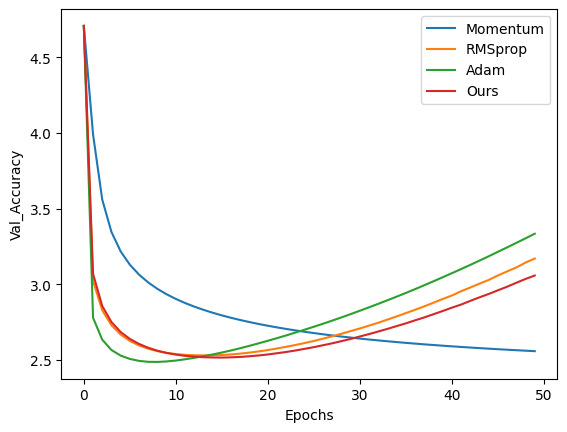

In [19]:
import matplotlib.pyplot as plt
import numpy as np
label_list = ["Momentum", "RMSProp", "Adam", "best_optim"]
Accuracy_dist = {}
score = 0.0
for label in label_list:
    paths = glob.glob(f"./save_scores_json//cifar100_{label}_try_loss_num*.json")
    accs = 0
    for path in paths:
        json_file = open(path)
        content = json.load(json_file)
        json_file.close()
        content = content.split("[")[-1].split("]")[0].split(",")
        tmp = [float(c) for c in content]
        accs = np.add(accs, tmp)
        if score < max(tmp):
            score = max(tmp)
    # print(label, score)
    Accuracy_dist[label] = np.divide(accs, len(paths))

labels = ["Momentum", "RMSprop", "Adam", "Ours"]
line_type = ["dotted", "dashdot", "dashed", "solid"]
fig, ax = plt.subplots()
lim = 50
for accs, label, line in zip(Accuracy_dist.values(),labels, line_type):
    # x = np.array(range(len(accs)))
    x = np.array(range(lim))
    print(label, min(accs))
    # ax.plot(x, accs[:lim], linestyle = line, label = label)
    ax.plot(x, accs[:lim], label = label)

ax.set_xlabel( "Epochs")
ax.set_ylabel("Val_Accuracy")
# ax.set_ylim(0, 0.4)
plt.legend()
plt.savefig("cifar100_vgg16_defalt.png")
plt.show()
